In [2]:
import numpy as np
from matplotlib import pyplot as plt

# 1. Прямая с шумом

Сгенерируем точки $(x_i, y_i)$ по закону
$$
    y = w_1 x + w_0 + \epsilon,
$$
где $\epsilon$ - случайная величина из нормального распределения, моделирующая разброс точек. 

In [104]:
# Возьмем $\epsilon \sim \mathcal{N}(0, 0.3)$. 

In [111]:
true_w1 = 1.7
true_w0 = 2.3
# print('True w:', true_w1, true_w0)

xs = np.arange(1, 5, 0.2)
noise = np.random.normal(0, 0.3, size=xs.shape)
ys = xs * true_w1 + true_w0 + noise
# [x * true_w1 + true_w0 for x in xs] -- BAD!

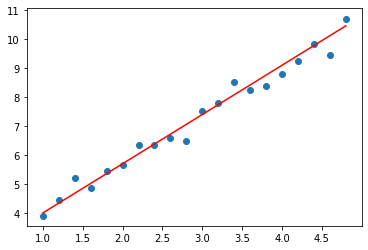

In [60]:
plt.scatter(xs, ys)
plt.plot(xs, ys - noise, c='r')
plt.show()

Применим формулы метода наименьших квадратов, выведенные на лекции:

$$
    \hat{w_1} = \sum_{i=1}^{l} \frac{(x_i - \bar{x})(y_i - \bar{y})} {(x_i - \bar{x})^2} = \frac{\hat{\text{cov}}(x, y)}{\hat{\text{var}} \, x}, \qquad \hat{w_0} = \bar{y} - \hat{w_1} \bar{x},
$$
где $\bar{x} = \frac{1}{l} \sum_{i=1}^{l} x_i$ и $\bar{y} = \frac{1}{l} \sum_{i=1}^{l} y_i$ - это средние по выборке.

Выборочные дисперсии и ковариация:
$$
    \hat{\text{var}} \, x = \frac{1}{l} \sum_{i=1}^{l} (x_i - \bar{x})^2 \qquad
    \hat{\text{var}} \, y = \frac{1}{l} \sum_{i=1}^{l} (y_i - \bar{y})^2 \qquad
    \hat{\text{cov}}(x, y) = \frac{1}{l} \sum_{i=1}^{l} (x_i - \bar{x})(y_i - \bar{y})
$$

In [51]:
var_x = np.mean((xs - xs.mean()) ** 2)
var_y = np.mean((ys - ys.mean()) ** 2)
cov_xy = np.mean((xs - xs.mean()) * (ys - ys.mean()))

(var_x, var_y, cov_xy)

(1.3299999999999994, 3.5751833551933485, 2.1563952051048996)

In [52]:
(np.var(xs), np.var(ys))

(1.3299999999999994, 3.5751833551933485)

In [55]:
np.cov([xs, ys], bias=True)

array([[1.33      , 2.15639521],
       [2.15639521, 3.57518336]])

In [57]:
(np.var(xs), np.var(ys), np.cov([xs, ys], bias=True)[0, 1])

(1.3299999999999994, 3.5751833551933485, 2.1563952051048996)

In [102]:
w1 = cov_xy / var_x
w0 = ys.mean() - w1 * xs.mean()

print('True w:', true_w1, true_w0)
print('Restored w:', w1, w0)

True w: 1.7 2.3
Restored w: 1.6213497782743613 2.4910069650169406


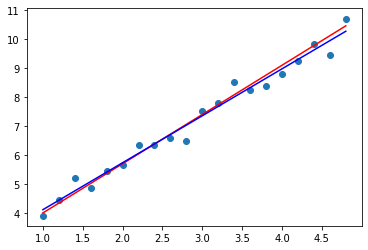

In [64]:
plt.scatter(xs, ys)
plt.plot(xs, ys - noise, c='r')
plt.plot(xs, xs * w1 + w0, c='b')
plt.show()

Посчитаем коэффицент линейной корреляции Пирсона:

$$
    r = \frac{\hat{\text{cov}}(x, y)}{\sqrt{ \hat{\text{var}} \, x \, \hat{\text{var}} \, y}}
$$

In [113]:
r = cov_xy / np.sqrt(var_x * var_y)
r

0.9889022775571071

Воспользуемся формализмом матрицы объект-признак и решением МНК через псевдообратную матрицу.

В нашем случае (1D регрессия с учетом смещения $\check{y} = w_1 x + w_0$) имеем два признака: сам $x$ и постоянный признак $1$, отвечающий смещению.  
$$
    X = \begin{pmatrix}
        x_1 & 1 \\
        x_2 & 1 \\
        \dots & \dots \\
        x_l & 1
    \end{pmatrix} 
    \qquad
    y = \begin{pmatrix}
        y_1 \\
        y_2 \\
        \dots \\
        y_l
    \end{pmatrix} 
$$

In [65]:
xs.shape

(20,)

In [87]:
X = xs.reshape((-1, 1))
X = np.hstack([xs.reshape(-1, 1), np.ones(X.shape)])
X.shape

(20, 2)

In [88]:
Q = np.linalg.inv(X.T @ X) @ X.T
np.round(Q @ X)

array([[1., 0.],
       [0., 1.]])

In [89]:
def left_pseudoinverse(X):
    return np.linalg.inv(X.T @ X) @ X.T

In [90]:
Q = left_pseudoinverse(X)
np.round(Q @ X)

array([[1., 0.],
       [0., 1.]])

In [91]:
w = Q @ ys
w

array([1.62134978, 2.49100697])

Учесть систематическую погрешность $y_i \pm s$ можно при помощи усреднения по ансамблю выборок (приборов), рассматривая случайную величину $\tilde{y_i} \sim \mathcal{N}(y_i, s^2)$.

Тогда, как было показано на лекции, для дисперсии параметров модели (весов) получим
$$
    \text{var} \, w_\alpha = s^2 [(X^T X)^{-1}]_{\alpha \alpha}
$$
И оценкой погрешности будет
$$
    \text{погрешность} \, w_\alpha \approx \sqrt{\text{var} \, w_\alpha} = s \sqrt{[(X^T X)^{-1}]_{\alpha \alpha}}
$$


Для учета погрешности полезно вычислить матрицу $(X^T X)^{-1}$

In [98]:
XTXinv = np.linalg.inv(X.T @ X)

In [101]:
print('Погрешность параметров (w1, w0) = s * ', (np.sqrt(XTXinv[0, 0]), np.sqrt(XTXinv[1, 1])))

Погрешность параметров (w1, w0) = s *  (0.19389168358237013, 0.6051160331158263)
